# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

from tqdm.auto import tqdm, trange
from unityagents import UnityEnvironment
import numpy as np
import torch
from agent import CompetetiveAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Solution for Tennis Environment with MADDPG type Reinforcement Learning

The environment to solve in this project is a Tennis environment with 2 players, which are being controlled by nearly-identical agents. Selected algorithm for this project is MADDPG. The version of MADDPG employed in this project is simply introducing individual agents with identical specs for each player, and train them by self-playing according to DDPG algorithm.

Hyper-parameters for the components of DDPG algorithm are defined below.

In [5]:
args = {
    "memory_size": 1e6,
    "batch_size": 512,
    "discount_factor": .99,
    "tau": .2,
    "lr_actor": 1e-4,
    "lr_critic": 5e-4,
    "weight_decay": 0,
}
termination_threshold = .5
max_episodes = 1e4
max_t = 1e3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

- Memory Size: Size of replay buffer
- Batch Size: Number of samples per batch
- Discount Factor (gamma):   Discount factor for feature q values
- Tau: Coefficient for the merge process between local networks and target networks.
- LR Actor: Learning rate for the local actor model
- LR Critic: Learning rate for the local critic model
- Weight Decay: Weight decay for critic network if it's necessary.
- Termination threshold: Termination threshold for the scores of training procedure.

The code below is a simple training loop that calls certain methods from the Competetive Agent class, which includes both players' agents and handles their interaction with the environment and their training procedure. One may simply think of it as a wrapper for a DDPG agent class to handle multiple agents according to MADDPG algorithm. 

In [6]:
agent = CompetetiveAgent(state_size, action_size, num_agents, args=args,
                                 device=device)

scores_deque = deque(maxlen=100)
scores = []
tqdm_bar = trange(1, int(max_episodes), desc="Episodes")
episode_bar = tqdm(total=max_t)
train_mode = True
add_noise = True
for i in tqdm_bar:
    agent.reset()
    states = env.reset(train_mode=train_mode)[brain_name].vector_observations
    episode_scores = np.zeros(num_agents)
    loss = []
    for t in range(int(max_t)):
        actions = agent.act(states, add_noise=add_noise)
        env_info = env.step(actions)[brain_name]
        next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
        curr_loss = agent.step(states, actions, rewards, next_states, dones)
        if curr_loss is not None:
            loss.append(curr_loss)
        states = next_states
        episode_scores += rewards
        episode_bar.set_description("Time Step T: {}, Score: {:.2f}".format(t, np.max(episode_scores)))
        episode_bar.update()
        if np.any(dones):
            break

    episode_bar.reset()

    if len(loss) > 0:
        if loss[-1][0] > .2:
            add_noise = False
        tqdm_bar.set_description("Score: {:.2f} Critic Loss: {:.2f} Actor Loss: {:.2f}".format(np.max(episode_scores), loss[-1][0], loss[-1][1]))
    scores_deque.append(episode_scores)
    scores.append(np.max(episode_scores))
    if i % 100 == 0:

        if np.mean(scores_deque) > termination_threshold:
            agent.save()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i - 100,
                                                                                         np.mean(scores_deque)))
            break

env.close()


Environment solved in 500 episodes!	Average Score: 0.80


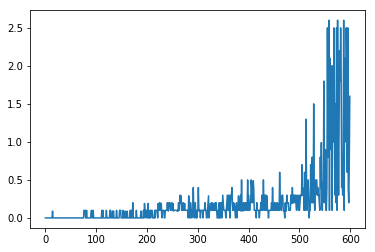

In [10]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

As it can be seen from the figure above, agents manage to solve the environment and get the top score at 2.6 - 2.7 level. 

## Future Works:
- Employing different models for each agent seems like a waste of resource as they are trying to solve same problems with different aspects. Merging models may be tried.
- Online methods can be employed and see how they work.
- Replay buffer samples uniformly currently. This is sub-optimal as not all experiences are worth equally. Prioritized experience replay can be adopted.

## Future Works:
- Employing different models for each agent seems like a waste of resource as they are trying to solve same problems with different aspects. Merging models may be tried.
- Online methods can be employed and see how they work.
- Replay buffer samples uniformly currently. This is sub-optimal as not all experiences are worth equally. Prioritized experience replay can be adopted.

## Future Works:
- Employing different models for each agent seems like a waste of resource as they are trying to solve same problems with different aspects. Merging models may be tried.
- Online methods can be employed and see how they work.
- Replay buffer samples uniformly currently. This is sub-optimal as not all experiences are worth equally. Prioritized experience replay can be adopted.